# Categorical Modelling

In [119]:
import pandas as pd

In [120]:
# Jon's weather data (instead of Alberta provincial)
df = pd.read_csv('JFE_data_18-19.csv', index_col=0)

# sort by date
df.sort_values(by='Date', inplace=True)

# make date the index
df.set_index('Date',inplace=True)

#to_drop = ['AvgTemp_7','AvgRH_7', 'AvgDP_7','Precip_7', 'MaxTemp_7',
 #      'MinTemp_7','SsMean_7']
#df.drop(labels=to_drop, axis=1, inplace=True)

## Two Categories

In [94]:
print(df.loc[df['SsMean'] < 250].SsMean.count())
print(df.loc[df['SsMean'] > 250].SsMean.count())

250
201


In [95]:
# create target
# 0 = less than 250
# 1 = over 250

In [96]:
def create_cat(data):
    if data < 250:
        return 0
    else:
        return 1

In [97]:
df['label'] = df['SsMean'].apply(create_cat)

### XGBC, no scaling

#### Ordered Test Set

In [ ]:
# split off end of 2019 as test set
test_size = df.shape[0] - 14
train, test = df.iloc[:test_size], df.iloc[test_size:]

X_train, X_test = train.drop(labels=['SsMean','logSsMean', 'label'], axis=1), test.drop(labels=['SsMean','logSsMean','label'], axis=1)
y_train, y_test = train.label, test.label

#### Random Test Set

In [140]:
from sklearn.model_selection import train_test_split
X = df.drop(labels=['SsMean','logSsMean', 'label'], axis=1)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

#### Model

In [139]:
# encode location
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(X_train['Location'])
X_train['Location'] = le.transform(X_train['Location'])
X_test['Location'] = le.transform(X_test['Location'])

KeyError: 'Location'

In [141]:
import xgboost as xgb

xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)

/Users/reneehall/opt/anaconda3/envs/lighthouse/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[10:34:59] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [142]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

Train accuracy: 1.0
Test accuracy: 0.8131868131868132
Train auc: 1.0
Test auc: 0.8472222222222223
Train precision: 1.0
Test precision: 0.6666666666666666
Train recall: 1.0
Test recall: 0.7407407407407407
F1 score train: 1.0
F1 score test: 0.7017543859649122
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        64
           1       0.67      0.74      0.70        27

    accuracy                           0.81        91
   macro avg       0.78      0.79      0.78        91
weighted avg       0.82      0.81      0.82        91



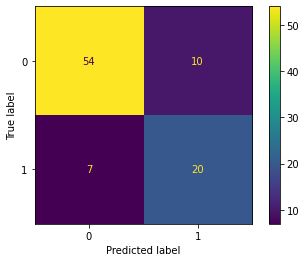

In [143]:
# from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(xg, X_test, y_test)

### XGBC with scaling

#### Ordered Test Set

In [ ]:
# split off end of 2019 as test set
test_size = df.shape[0] - 14
train, test = df.iloc[:test_size], df.iloc[test_size:]

X_train, X_test = train.drop(labels=['SsMean','logSsMean', 'label'], axis=1), test.drop(labels=['SsMean','logSsMean','label'], axis=1)
y_train, y_test = train.label, test.label

#### Random Test Set

In [105]:
from sklearn.model_selection import train_test_split
X = df.drop(labels=['SsMean','logSsMean', 'label'], axis=1)
y = df.label

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

#### Model

In [106]:
from sklearn.preprocessing import StandardScaler

# encode location
le = LabelEncoder()
le.fit(X_train['Location'])
X_train['Location'] = le.transform(X_train['Location'])
X_test['Location'] = le.transform(X_test['Location'])

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

<ipython-input-106-a169bd59956c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Location'] = le.transform(X_train['Location'])
<ipython-input-106-a169bd59956c>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Location'] = le.transform(X_test['Location'])


In [107]:
xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)

/Users/reneehall/opt/anaconda3/envs/lighthouse/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:26:11] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [109]:
y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

Train accuracy: 1.0
Test accuracy: 0.7692307692307693
Train auc: 1.0
Test auc: 0.8463463463463463
Train precision: 1.0
Test precision: 0.6739130434782609
Train recall: 1.0
Test recall: 0.8378378378378378
F1 score train: 1.0
F1 score test: 0.746987951807229
              precision    recall  f1-score   support

           0       0.87      0.72      0.79        54
           1       0.67      0.84      0.75        37

    accuracy                           0.77        91
   macro avg       0.77      0.78      0.77        91
weighted avg       0.79      0.77      0.77        91



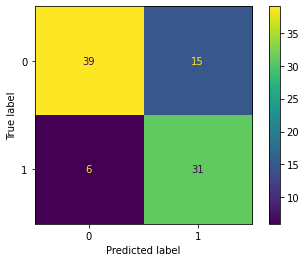

In [110]:
plot_confusion_matrix(xg, X_test, y_test)

## 500+ label

In [121]:
print(df.loc[df['SsMean'] < 500].SsMean.count())
print(df.loc[df['SsMean'] > 500].SsMean.count())

319
132


In [122]:
# create target
# 0 = less than 500
# 1 = over 500

def create_500(data):
    if data < 500:
        return 0
    else:
        return 1

In [123]:
df['label'] = df['SsMean'].apply(create_500)

In [124]:
# create balanced dataset
class_0 = df.loc[df['label']==0]
class_1 = df.loc[df['label']==1]

class_1_sample = class_1.sample(n=377, replace=True)

bdf = pd.concat([class_0, class_1_sample], axis=0)
bdf.sort_values(by='Date', inplace=True)

In [125]:
bdf.shape

(696, 61)

### XGBC, scaling, 500+ label

#### Ordered Test Set

In [ ]:
# split off end of 2019 as test set
test_size = bdf.shape[0] - 14
train, test = bdf.iloc[:test_size], bdf.iloc[test_size:]

X_train, X_test = train.drop(labels=['SsMean','logSsMean', 'label'], axis=1), test.drop(labels=['SsMean','logSsMean','label'], axis=1)
y_train, y_test = train.label, test.label

#### Random Test Set

In [131]:
X = bdf.drop(labels=['SsMean','logSsMean', 'label'], axis=1)
y = bdf.label

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

#### Model

In [132]:
# encode location
le = LabelEncoder()
le.fit(X_train['Location'])
X_train['Location'] = le.transform(X_train['Location'])
X_test['Location'] = le.transform(X_test['Location'])

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)

<ipython-input-132-86dd1da13430>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Location'] = le.transform(X_train['Location'])
<ipython-input-132-86dd1da13430>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Location'] = le.transform(X_test['Location'])
/Users/reneehall/opt/anaconda3/envs/lighthouse/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

[13:39:30] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train accuracy: 1.0
Test accuracy: 0.8785714285714286
Train auc: 1.0
Test auc: 0.9756695972193824
Train precision: 1.0
Test precision: 0.8255813953488372
Train recall: 1.0
Test recall: 0.9726027397260274
F1 score train: 1.0
F1 score test: 0.8930817610062893
              precision    recall  f1-score   support

           0       0.96      0.78      0.86        67
           1       0.83      0.97      0.89        73

    accuracy                           0.88       140
   macro avg       0.89      0.87      0.88       140
weighted avg       0.89      0.88      0.88       140



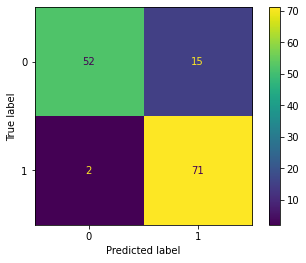

In [133]:
y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

plot_confusion_matrix(xg, X_test, y_test)

### XGBC, no scaling, 500+

#### Ordered Test Set

In [ ]:
# split off end of 2019 as test set
test_size = bdf.shape[0] - 14
train, test = bdf.iloc[:test_size], bdf.iloc[test_size:]

X_train, X_test = train.drop(labels=['SsMean','logSsMean', 'label'], axis=1), test.drop(labels=['SsMean','logSsMean','label'], axis=1)
y_train, y_test = train.label, test.label

#### Random Test Set

In [135]:
X = bdf.drop(labels=['SsMean','logSsMean', 'label'], axis=1)
y = bdf.label

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=46)

#### Model

In [136]:
# encode location
le = LabelEncoder()
le.fit(X_train['Location'])
X_train['Location'] = le.transform(X_train['Location'])
X_test['Location'] = le.transform(X_test['Location'])

xg = xgb.XGBClassifier()
xg.fit(X_train, y_train)

<ipython-input-136-1d60d416afa3>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['Location'] = le.transform(X_train['Location'])
<ipython-input-136-1d60d416afa3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Location'] = le.transform(X_test['Location'])
/Users/reneehall/opt/anaconda3/envs/lighthouse/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do th

[13:41:24] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Train accuracy: 1.0
Test accuracy: 0.8785714285714286
Train auc: 1.0
Test auc: 0.9756695972193824
Train precision: 1.0
Test precision: 0.8255813953488372
Train recall: 1.0
Test recall: 0.9726027397260274
F1 score train: 1.0
F1 score test: 0.8930817610062893
              precision    recall  f1-score   support

           0       0.96      0.78      0.86        67
           1       0.83      0.97      0.89        73

    accuracy                           0.88       140
   macro avg       0.89      0.87      0.88       140
weighted avg       0.89      0.88      0.88       140



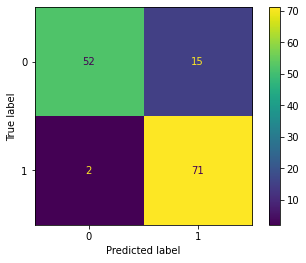

In [137]:
y_pred = xg.predict(X_test)
y_train_pred = xg.predict(X_train)

test_acc = xg.score(X_test, y_test)
train_acc = xg.score(X_train, y_train)
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)

train_probs = xg.predict_proba(X_train)[:,1]
train_auc = roc_auc_score(y_train,train_probs)
print('Train auc:', train_auc)
test_probs = xg.predict_proba(X_test)[:,1]
test_auc = roc_auc_score(y_test,test_probs)
print('Test auc:', test_auc)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_pred)
print('Train precision:', train_precision)
print('Test precision:', test_precision)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_pred)
print('Train recall:', train_recall)
print('Test recall:', test_recall)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_pred)
print('F1 score train:', train_f1)
print('F1 score test:', test_f1)

cr = classification_report(y_test,y_pred)
print(cr)

plot_confusion_matrix(xg, X_test, y_test)

In [113]:
r_df = pd.DataFrame(test)
r_df['pred'] = y_pred
r_df.reset_index(inplace=True)

In [114]:
incorrect = r_df[r_df['label'] != r_df['pred']]
correct = r_df[r_df['label'] == r_df['pred']]

In [119]:
wrong_df = pd.DataFrame()
for i in incorrect.index.tolist():
    wrong_df = wrong_df.append(test.iloc[i])
    
right_df = pd.DataFrame()
for i in correct.index.tolist():
    right_df = right_df.append(test.iloc[i])

In [120]:
wrong_df.columns

Index(['AvgDP', 'AvgDP_1', 'AvgDP_3', 'AvgDP_7', 'AvgRH', 'AvgRH_1', 'AvgRH_3',
       'AvgRH_7', 'AvgTemp', 'AvgTemp_1', 'AvgTemp_3', 'AvgTemp_7',
       'AvgWindSpeed', 'Date', 'JDay', 'Location', 'MaxTemp', 'MaxTemp_1',
       'MaxTemp_3', 'MaxTemp_7', 'MinTemp', 'MinTemp_1', 'MinTemp_3',
       'MinTemp_7', 'Precip', 'Precip_1', 'Precip_3', 'Precip_7', 'SsMean',
       'SsMean_1', 'SsMean_3', 'SsMean_7', 'YearWeek', 'label', 'logSsMean',
       'month', 'precip_3dTotal', 'pred', 'year'],
      dtype='object')

In [136]:
cols = ['AvgDP_1', 'AvgDP_3', 'AvgDP_7', 'AvgRH_1', 'AvgRH_3',
       'AvgRH_7', 'AvgTemp_1', 'AvgTemp_3', 'AvgTemp_7',
       'Location', 'MaxTemp_1',
       'MaxTemp_3', 'MaxTemp_7', 'MinTemp_1', 'MinTemp_3',
       'MinTemp_7', 'Precip_3', 'Precip_7', 'SsMean',
       'SsMean_1', 'SsMean_3',
       'pred']

wrong_df[cols]

,AvgDP_1,AvgDP_3,AvgDP_7,AvgRH_1,AvgRH_3,AvgRH_7,AvgTemp_1,AvgTemp_3,AvgTemp_7,Location,...,MaxTemp_7,MinTemp_1,MinTemp_3,MinTemp_7,Precip_3,Precip_7,SsMean,SsMean_1,SsMean_3,pred
8,11.10,11.800000,10.282857,56.0,58.500000,62.628571,19.9,20.1,17.757143,2.0,...,26.542857,12.9,12.266667,9.700000,0.866667,0.657143,2379.4,2362.23,863.873333,0.0
17,9.88,11.046667,10.605714,83.9,70.733333,64.242857,13.1,16.9,17.757143,2.0,...,26.528571,7.7,10.366667,9.571429,0.866667,0.800000,768.5,2379.40,1629.076667,0.0
20,9.88,11.046667,10.605714,83.9,70.733333,64.242857,13.1,16.9,17.757143,2.0,...,26.528571,7.7,10.366667,9.571429,0.866667,0.800000,768.5,2379.40,1629.076667,0.0


In [137]:
right_df[cols]

,AvgDP_1,AvgDP_3,AvgDP_7,AvgRH_1,AvgRH_3,AvgRH_7,AvgTemp_1,AvgTemp_3,AvgTemp_7,Location,...,MaxTemp_7,MinTemp_1,MinTemp_3,MinTemp_7,Precip_3,Precip_7,SsMean,SsMean_1,SsMean_3,pred
0,11.40,12.226667,10.377143,72.5,64.300000,66.885714,16.9,19.366667,17.000000,4.0,...,24.800000,8.7,12.066667,10.371429,0.966667,1.071429,2260.510,135.420,595.573333,1.0
1,12.38,13.333333,11.211429,67.4,65.333333,63.985714,18.9,20.266667,18.414286,5.0,...,26.628571,9.4,11.966667,10.042857,1.166667,0.714286,936.380,132.570,1058.526667,1.0
2,11.40,12.226667,10.377143,72.5,64.300000,66.885714,16.9,19.366667,17.000000,4.0,...,24.800000,8.7,12.066667,10.371429,0.966667,1.071429,2260.510,135.420,595.573333,1.0
3,12.38,13.333333,11.211429,67.4,65.333333,63.985714,18.9,20.266667,18.414286,5.0,...,26.628571,9.4,11.966667,10.042857,1.166667,0.714286,936.380,132.570,1058.526667,1.0
4,11.40,12.226667,10.342857,72.5,64.300000,63.714286,16.9,19.366667,17.600000,3.0,...,26.157143,8.7,12.066667,10.071429,0.966667,0.528571,16864.435,249.440,259.771667,1.0
5,12.16,12.620000,10.634286,72.3,64.600000,65.242857,17.7,19.700000,17.585714,1.0,...,25.771429,10.5,12.266667,9.700000,0.866667,0.657143,1472.790,308.880,571.583333,1.0
6,12.18,12.440000,11.917143,71.4,62.533333,68.800000,17.9,19.933333,18.157143,0.0,...,25.871429,11.1,12.833333,11.857143,1.333333,0.771429,389.480,34.300,53.850000,0.0
7,12.38,13.333333,11.211429,67.4,65.333333,63.985714,18.9,20.266667,18.414286,5.0,...,26.628571,9.4,11.966667,10.042857,1.166667,0.714286,936.380,132.570,1058.526667,1.0
9,10.72,12.426667,11.608571,45.6,63.300000,59.757143,21.6,19.766667,19.657143,5.0,...,27.814286,14.2,12.766667,10.871429,0.766667,0.571429,84.000,936.380,384.130000,0.0
10,10.92,12.206667,11.682857,53.6,67.033333,63.985714,20.2,18.800000,18.885714,0.0,...,27.114286,12.9,12.533333,11.842857,1.366667,0.671429,26.930,389.480,145.020000,0.0
